In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import glob
import os
import doubletdetection
from scipy.stats import median_abs_deviation as mad
import numpy as np

# 6.3 Filtering low quality cells

AnnData object with n_obs × n_vars = 2990 × 33538
    var: 'gene_ids', 'feature_types'


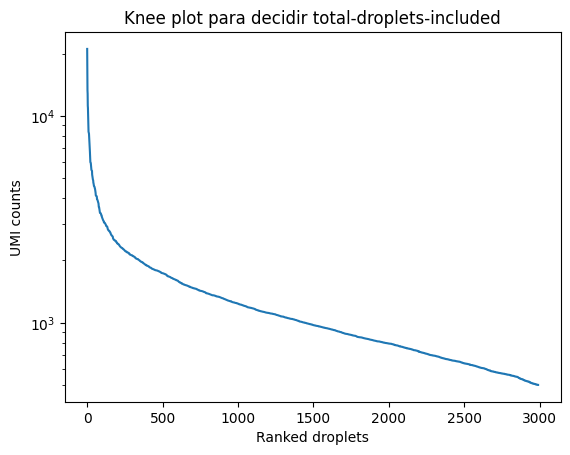

In [ ]:

adata = sc.read_10x_mtx(
    r"GSE157827_RAW\GSM4775565_AD6",
    var_names="gene_symbols",
    cache=True
)
adata.write(r"GSE157827_RAW\GSM4775565_AD6\GSM4775565_AD6.h5ad")
print(adata)

# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

ribo_adata = pd.DataFrame(adata.var['hb'])
ribo_adata = pd.DataFrame(adata.var['mt'])
ribo_adata = pd.DataFrame(adata.var['ribo'])

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

umi_counts = adata.obs["total_counts"].sort_values(ascending=False)

import matplotlib.pyplot as plt
plt.plot(range(len(umi_counts)), umi_counts)
plt.yscale("log")
plt.xlabel("Ranked droplets")
plt.ylabel("UMI counts")
plt.title("Knee plot para decidir total-droplets-included")
plt.show()

In [84]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [ ]:
ribo_adata = pd.DataFrame(adata.var['hb'])

,hb
HBEGF,True
HBS1L,True
HBB,True
HBD,True
HBG1,True
HBG2,True
HBE1,True
HBZ,True
HBM,True
HBA2,True


In [ ]:
ribo_adata = pd.DataFrame(adata.var['mt'])

,mt
MT-ND1,True
MT-ND2,True
MT-CO1,True
MT-CO2,True
MT-ATP8,True
MT-ATP6,True
MT-CO3,True
MT-ND3,True
MT-ND4L,True
MT-ND4,True


In [ ]:
ribo_adata = pd.DataFrame(adata.var['ribo'])

,ribo
RPL22,True
RPL11,True
RPS6KA1,True
RPS8,True
RPL5,True
...,...
RPS5,True
RPS4Y1,True
RPS4Y2,True
RPL3,True


In [88]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 3794 × 33538
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

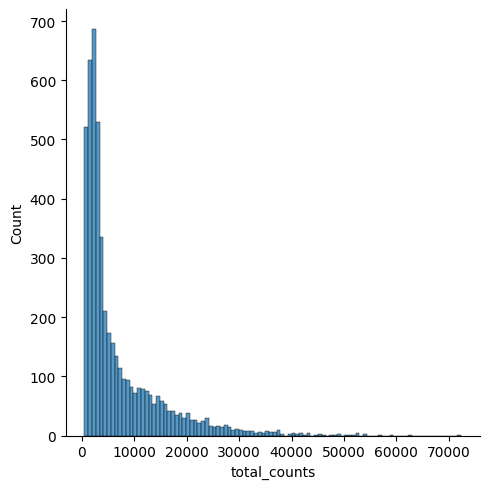

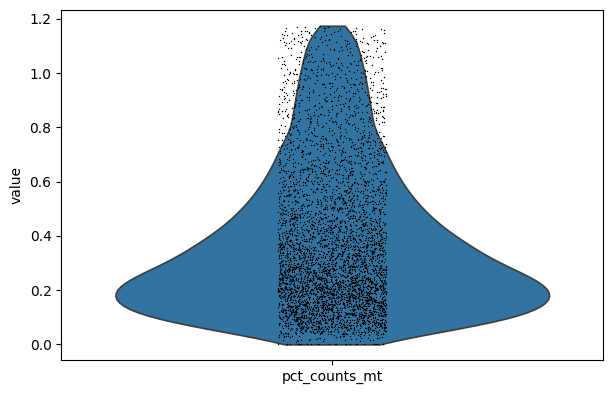

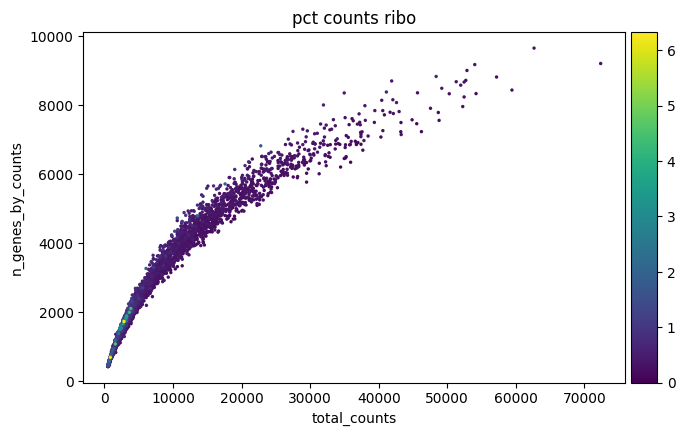

In [58]:
import seaborn as sns
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_ribo")

In [60]:
fig = px.histogram(adata.obs["total_counts"],nbins=1500)
fig.update_xaxes(range=[0, 5000])
fig.show()

In [56]:
from scipy.stats import median_abs_deviation

def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 6243
Number of cells after filtering of low quality cells: 4966


# 6.4 Correction of ambient RNA

ESTO lo he hecho con cellbender

# QC integrado con todas las muestras

In [ ]:
import os

base_dir = r"GSE157827_RAW\clean_data"

adatas = []

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith("filtered.h5"):
            adatas.append(file)

adatas


['AD10_filtered.h5',
 'AD13_filtered.h5',
 'AD19_filtered.h5',
 'AD1_filtered.h5',
 'AD20_filtered.h5',
 'AD21_filtered.h5',
 'AD2_filtered.h5',
 'AD4_filtered.h5',
 'AD5_filtered.h5',
 'AD6_filtered.h5',
 'AD8_filtered.h5',
 'AD9_filtered.h5',
 'NC11_filtered.h5',
 'NC12_filtered.h5',
 'NC14_filtered.h5',
 'NC15_filtered.h5',
 'NC16_filtered.h5',
 'NC17_filtered.h5',
 'NC18_filtered.h5',
 'NC3_filtered.h5',
 'NC7_filtered.h5']

In [3]:
def load_it(adata):
    samp = adata.split('_')[0]
    adata = sc.read_10x_h5(r'GSE157827_RAW\\clean_data\\' + adata)
    adata.obs['Patient'] = samp
    adata.obs.index = adata.obs.index + '-' + samp
    return adata

adatas = [load_it(ad) for ad in adatas]

def qc(adata):
    sc.pp.filter_cells(adata, min_genes = 200)
    
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)

    remove = ['total_counts_mt', 'log1p_total_counts_mt', 'total_counts_ribo', 
          'log1p_total_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb']
    
    adata.obs = adata.obs[[x for x in adata.obs.columns if x not in remove]]
    
    return adata

adatas = [qc(ad) for ad in adatas]
adatas_before = [ad.copy() for ad in adatas]

from scipy.stats import median_abs_deviation

def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

clf = doubletdetection.BoostClassifier(
    n_iters=10,
    n_jobs=-1)

def pp(adata):

    cells_removed = adata.n_obs
    
    adata.obs["outlier"] = (
        is_outlier(adata, "log1p_total_counts", 5)
        | is_outlier(adata, "log1p_n_genes_by_counts", 5)
        | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
    )
    adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
        adata.obs["pct_counts_mt"] > 20
    )

    adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
    cells_removed = cells_removed - adata.n_obs
    adata.uns['cells_removed'] = cells_removed

    doublets = clf.fit(adata.X).predict(p_thresh=1e-3, voter_thresh=0.5)
    doublet_score = clf.doublet_score()

    adata.obs["doublet"] = doublets
    adata.obs["doublet_score"] = doublet_score

    adata.uns['doublets_removed'] = adata.obs.doublet.sum()
    adata = adata[adata.obs.doublet == 0]
    return adata

adatas = [pp(ad) for ad in adatas]
adatas_after = adatas.copy()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
for adata in adatas:
    adata.write(f"GSE157827_RAW\clean_data\{adata.obs['Patient'][0]}_quality_control.h5")

<string>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\c'
<string>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\c'
C:\Users\User\AppData\Local\Temp\ipykernel_17776\3349873413.py:2: SyntaxWarning: invalid escape sequence '\{'
  adata.write(f"GSE157827_RAW\clean_data\{adata.obs['Patient'][0]}_quality_control.h5")
C:\Users\User\AppData\Local\Temp\ipykernel_17776\3349873413.py:2: SyntaxWarning: invalid escape sequence '\c'
  adata.write(f"GSE157827_RAW\clean_data\{adata.obs['Patient'][0]}_quality_control.h5")
C:\Users\User\AppData\Local\Temp\ipykernel_17776\3349873413.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

In [4]:
import gc
del adatas_before, adatas_after
gc.collect()

60

In [6]:
%matplotlib inline

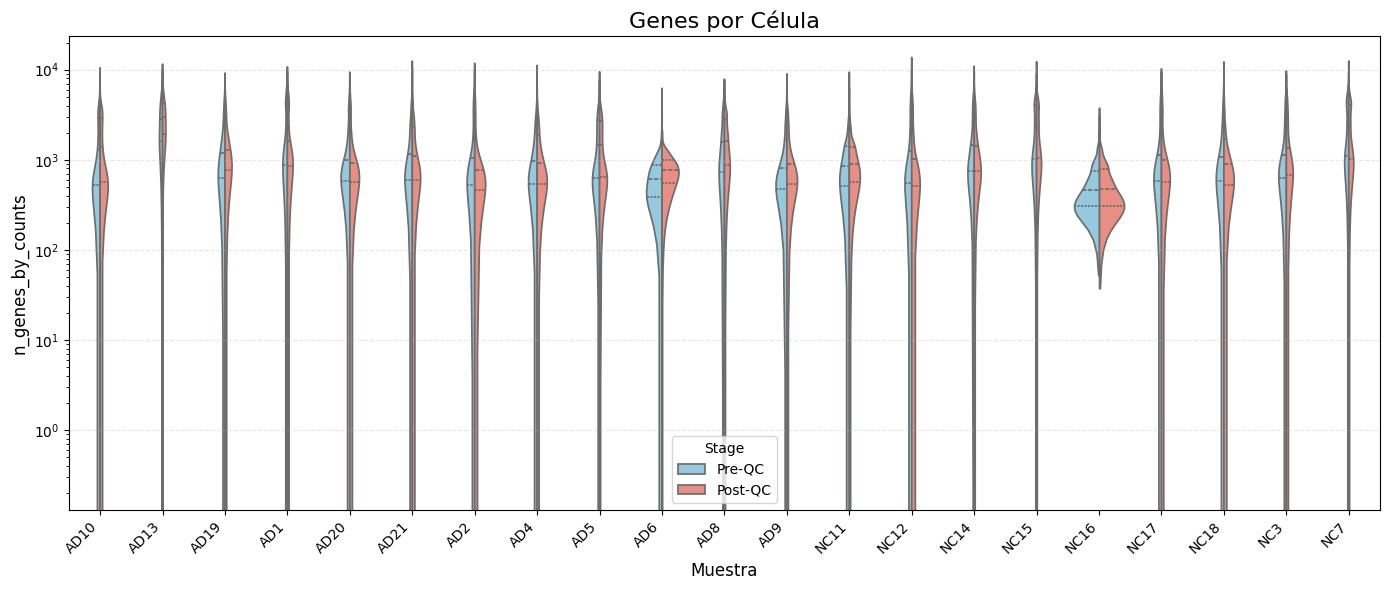

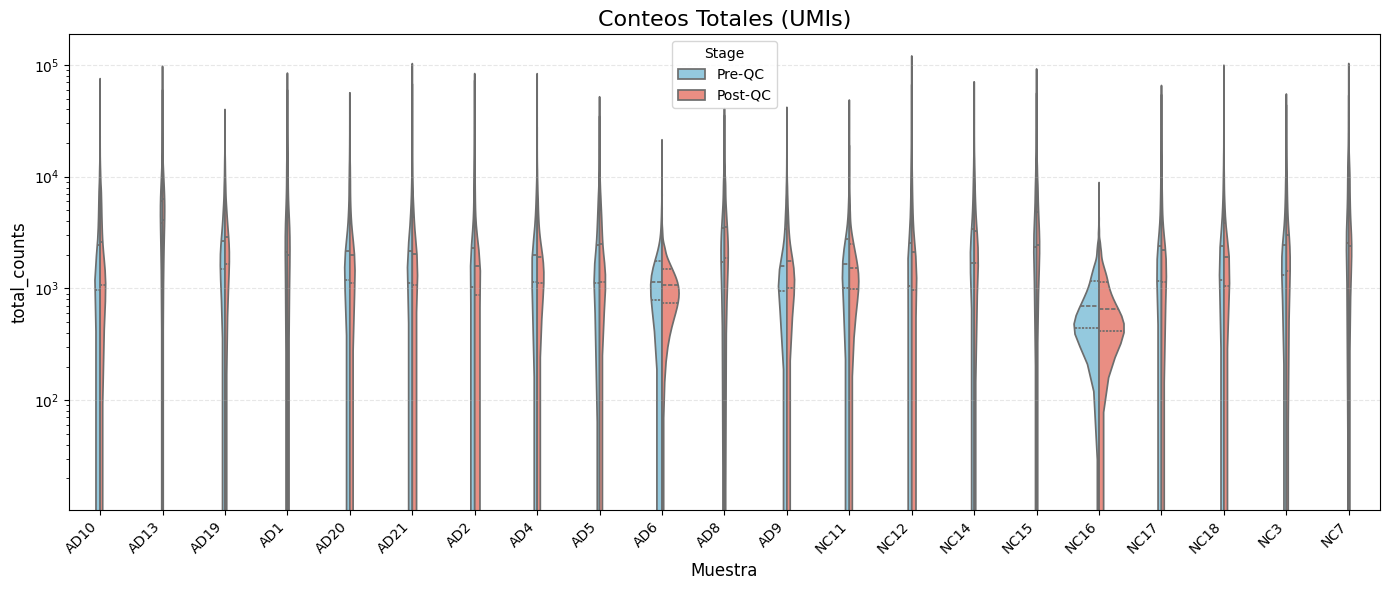

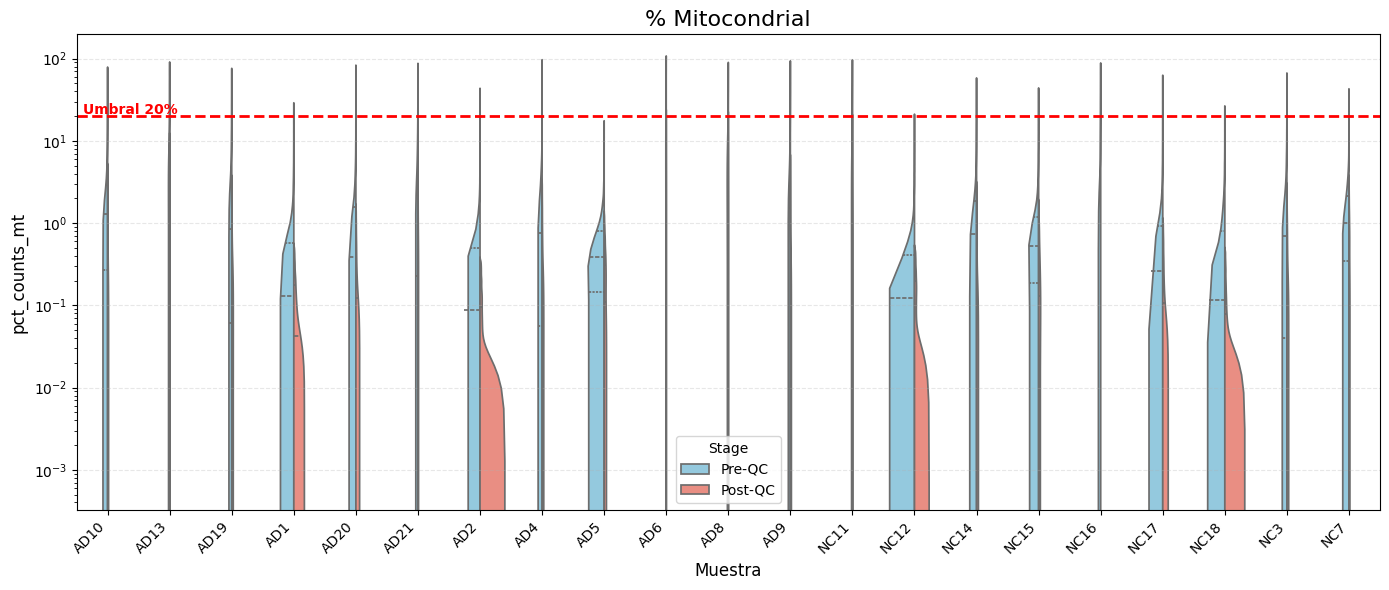

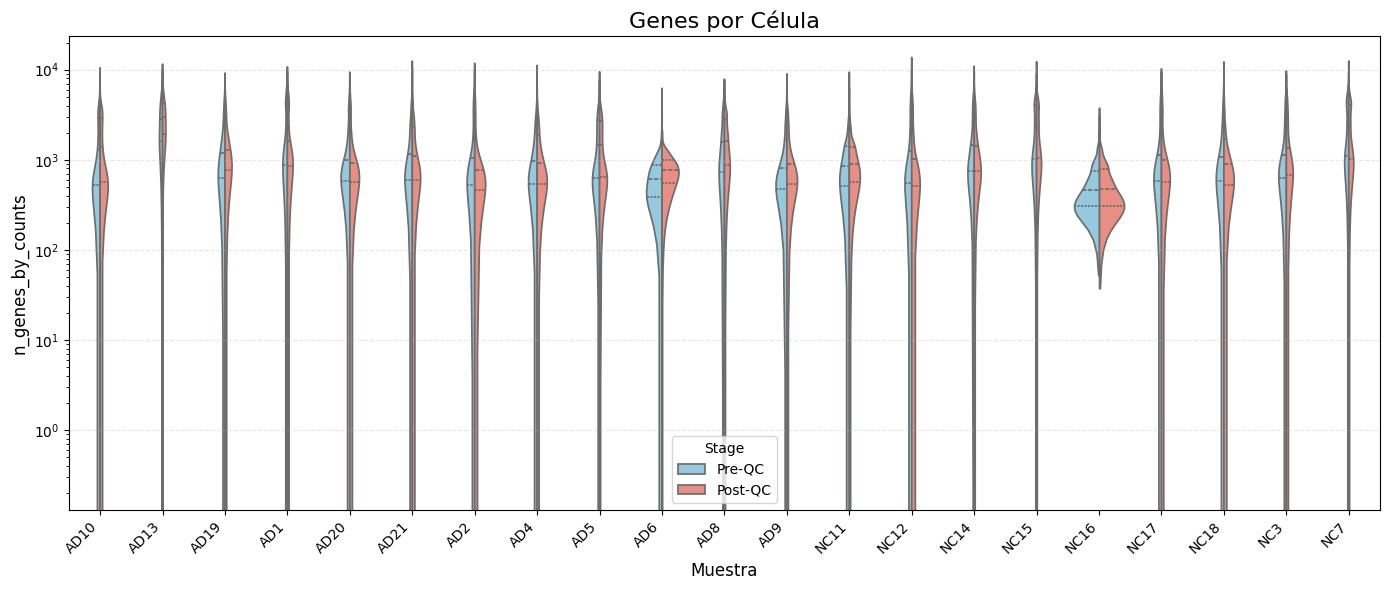

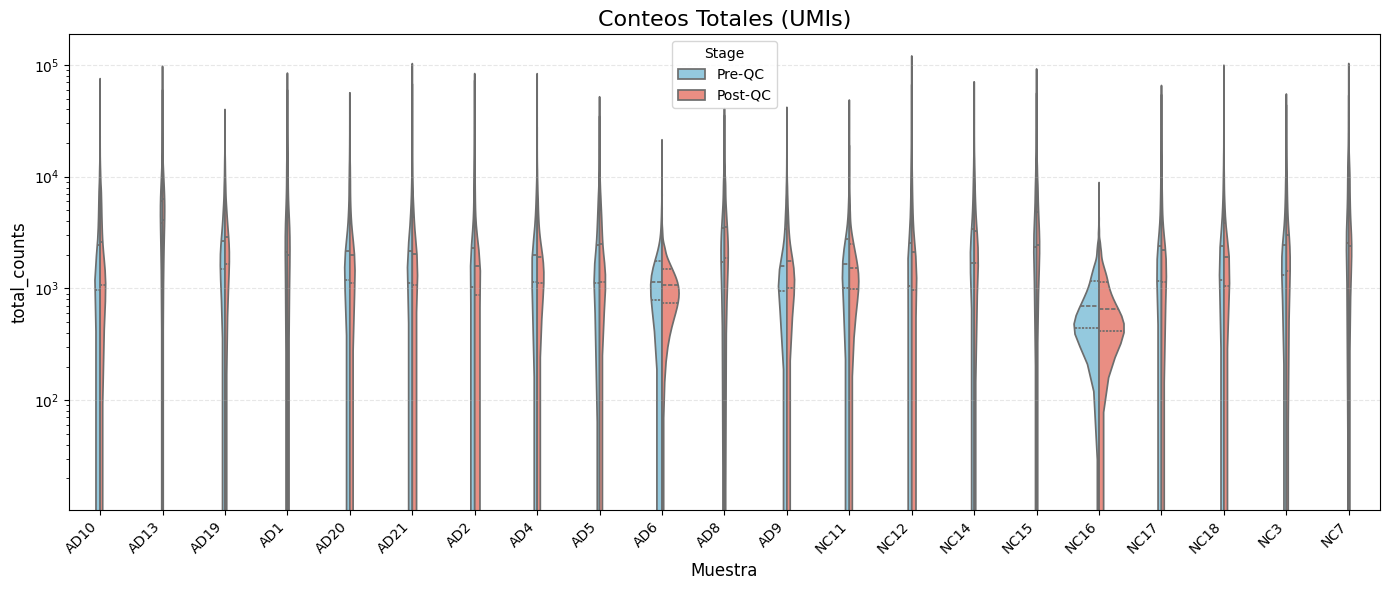

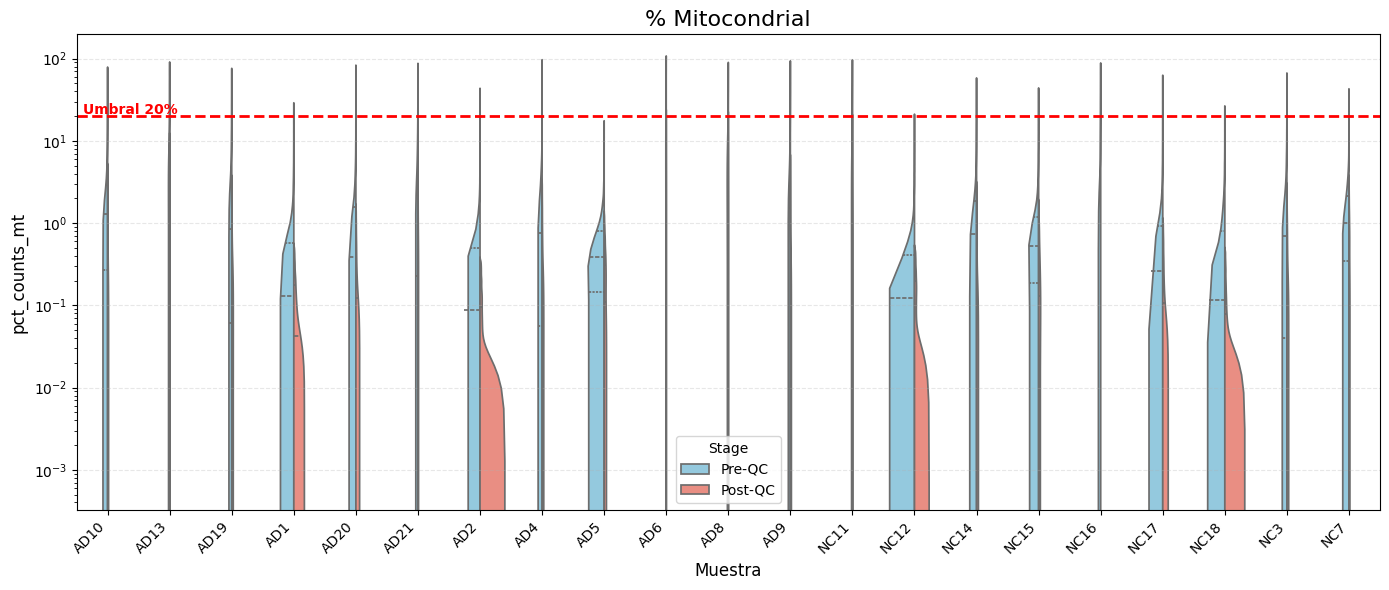

In [ ]:
def prepare_for_plotting(adatas_list, stage_label):
    temp_concat = sc.concat(adatas_list)
    df = temp_concat.obs.copy()
    df['Stage'] = stage_label
    return df

df_before = prepare_for_plotting(adatas_before, 'Pre-QC')

df_after = prepare_for_plotting(adatas_after, 'Post-QC')

df_plot = pd.concat([df_before, df_after])

# ---------------------------------------

metrics_info = {
    'n_genes_by_counts': {'title': 'Genes por Célula', 'log': True},
    'total_counts':      {'title': 'Conteos Totales (UMIs)', 'log': True},
    'pct_counts_mt':     {'title': '% Mitocondrial', 'log': False}
}

for metric, info in metrics_info.items():
    
    plt.figure(figsize=(14, 6))
    
    ax = sns.violinplot(
        data=df_plot,
        x="Patient",
        y=metric,
        hue="Stage",
        split=True,
        inner="quartile",
        palette={"Pre-QC": "skyblue", "Post-QC": "salmon"}
    )
    
    plt.title(info['title'], fontsize=16)
    plt.xlabel("Muestra", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.yscale('log')
        
    if metric == 'pct_counts_mt':
        plt.axhline(y=20, color='red', linestyle='--', linewidth=2)
        plt.text(x=-0.4, y=21, s='Umbral 20%', color='red', fontweight='bold')

    plt.tight_layout()
    plt.show()

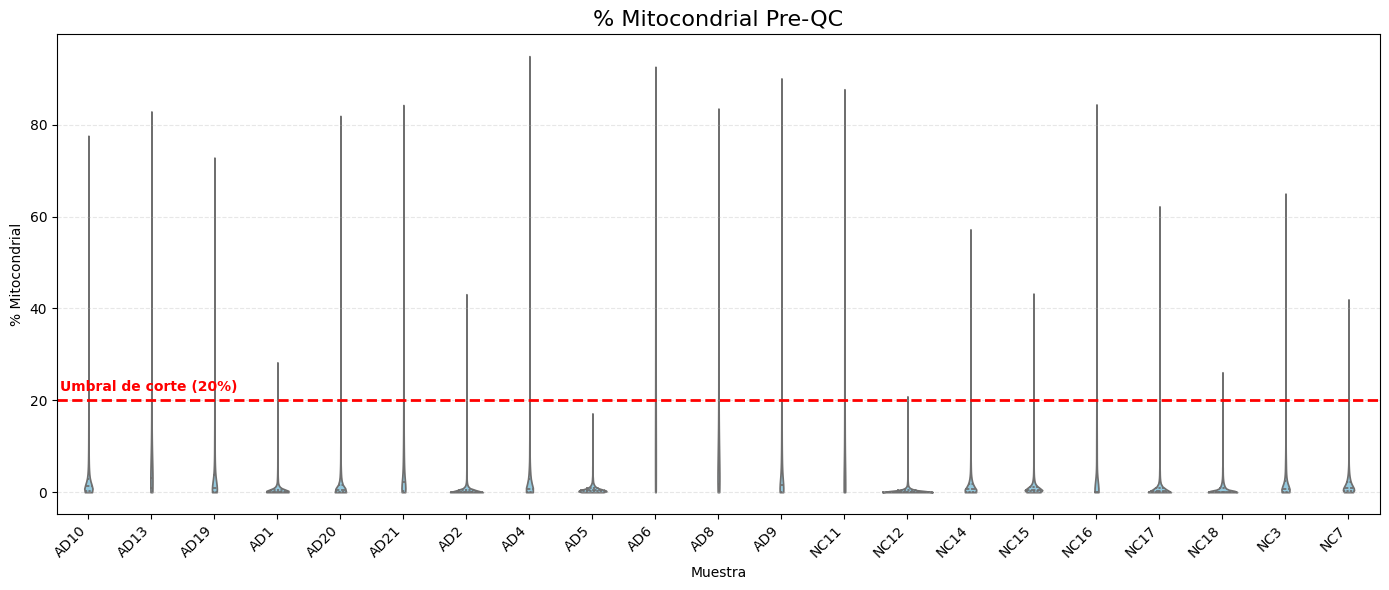

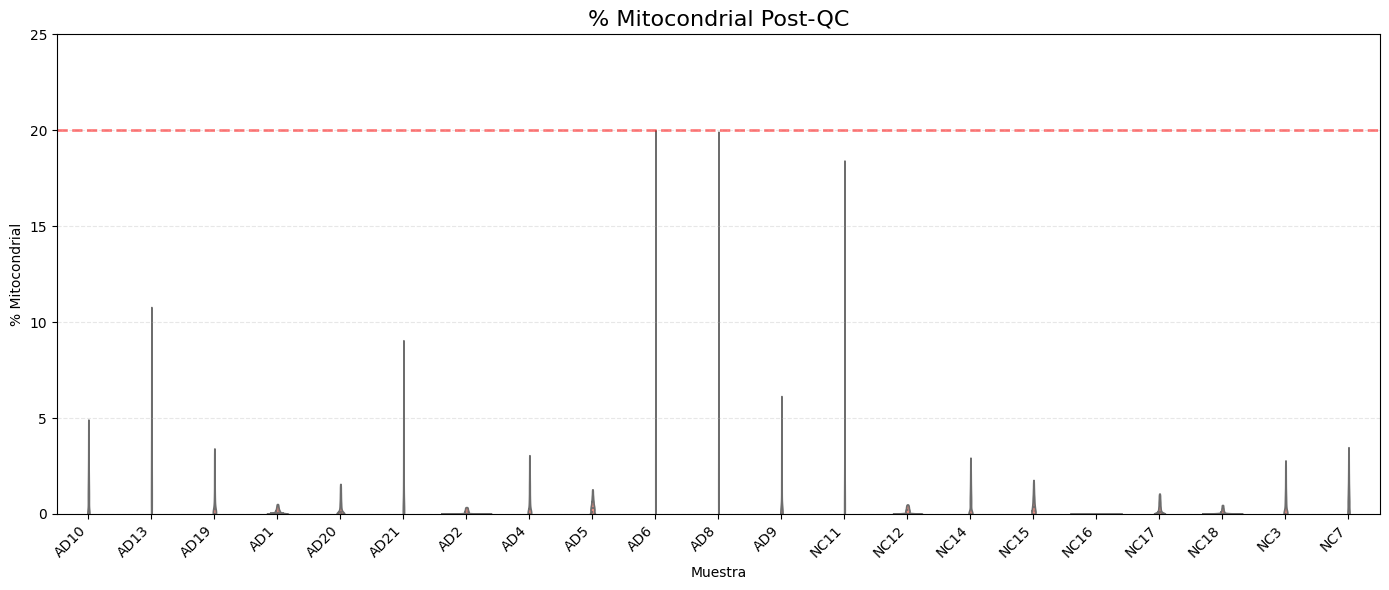

In [8]:
metric = 'pct_counts_mt'
red_line_height = 20

plt.figure(figsize=(14, 6))

data_before = df_plot[df_plot['Stage'] == 'Pre-QC']

sns.violinplot(
    data=data_before,
    x="Patient",
    y=metric,
    color="skyblue",
    inner="quartile",
    cut=0
)

plt.axhline(y=red_line_height, color='red', linestyle='--', linewidth=2)
plt.text(x=-0.45, y=red_line_height + 2, s='Umbral de corte (20%)', color='red', fontweight='bold')

plt.title('% Mitocondrial Pre-QC', fontsize=16)
plt.xlabel("Muestra")
plt.ylabel("% Mitocondrial")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))

data_after = df_plot[df_plot['Stage'] == 'Post-QC']

sns.violinplot(
    data=data_after,
    x="Patient",
    y=metric,
    color="salmon",
    inner="quartile",
    cut=0
)

plt.axhline(y=red_line_height, color='red', linestyle='--', linewidth=2, alpha=0.5)

plt.title('% Mitocondrial Post-QC', fontsize=16)
plt.xlabel("Muestra")
plt.ylabel("% Mitocondrial")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.ylim(0, 25) 

plt.tight_layout()
plt.show()

# Remove outliers and doublets

In [8]:
import doubletdetection
from scipy.stats import median_abs_deviation as mad
import numpy as np

In [9]:
%matplotlib inline


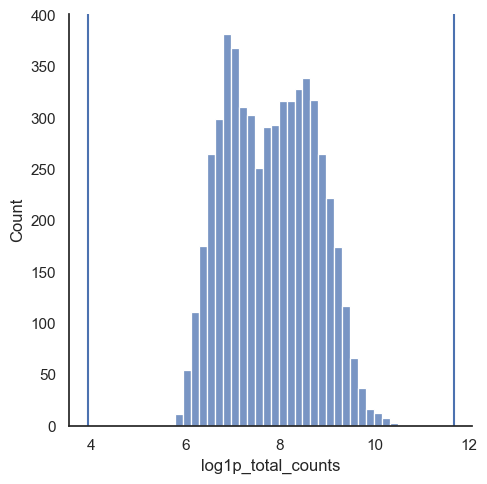

In [15]:
ax = sns.displot(a)

plt.axvline(np.median(a) - 5 * mad(a))
plt.axvline(np.median(a) + 5 * mad(a))

plt.show()

In [10]:
from scipy.stats import median_abs_deviation

def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

adatas[0].obs["outlier"] = (
    is_outlier(adatas[0], "log1p_total_counts", 5)
    | is_outlier(adatas[0], "log1p_n_genes_by_counts", 5)
    | is_outlier(adatas[0], "pct_counts_in_top_20_genes", 5)
)
adatas[0].obs.outlier.value_counts()

outlier
False    11633
True        84
Name: count, dtype: int64

In [11]:
adatas[0].obs["mt_outlier"] = is_outlier(adatas[0], "pct_counts_mt", 3) | (
    adatas[0].obs["pct_counts_mt"] > 8
)
adatas[0].obs.mt_outlier.value_counts()

mt_outlier
False    10104
True      1613
Name: count, dtype: int64

In [12]:
clf = doubletdetection.BoostClassifier(
    n_iters=10,
    n_jobs=-1)

In [13]:
def pp(adata):

    cells_removed = adata.n_obs
    
    adata.obs["outlier"] = (
        is_outlier(adata, "log1p_total_counts", 5)
        | is_outlier(adata, "log1p_n_genes_by_counts", 5)
        | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
    )
    adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
        adata.obs["pct_counts_mt"] > 8
    )

    adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
    cells_removed = cells_removed - adata.n_obs
    adata.uns['cells_removed'] = cells_removed

    doublets = clf.fit(adata.X).predict(p_thresh=1e-3, voter_thresh=0.5)
    doublet_score = clf.doublet_score()

    adata.obs["doublet"] = doublets
    adata.obs["doublet_score"] = doublet_score

    adata.uns['doublets_removed'] = adata.obs.doublet.sum()
    adata = adata[adata.obs.doublet == 0]
    return adata

In [14]:
adatas = [pp(ad) for ad in adatas]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
for adata in adatas:
    print(len(adata), adata.uns['cells_removed'], adata.uns['doublets_removed'])

9358 1624 726.0
347 119 0.0
1706 656 99.0
2390 1028 75.0
4176 1512 202.0
3225 1173 443.0
6949 3415 434.0
2352 764 164.0
4353 781 516.0
159 347 0.0
718 483 2.0
3988 1525 218.0
706 577 47.0
8632 2446 727.0
5896 1192 788.0
3598 737 306.0
1781 1474 14.0
6922 2145 735.0
5395 3038 494.0
2824 898 115.0
3002 491 465.0


In [16]:
for adata in adatas:
    adata.write(f"GSE157827_RAW\clean_data\{adata.obs['Patient'][0]}_quality_control.h5")

<string>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\c'
<string>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\c'
C:\Users\User\AppData\Local\Temp\ipykernel_27500\3349873413.py:2: SyntaxWarning: invalid escape sequence '\{'
  adata.write(f"GSE157827_RAW\clean_data\{adata.obs['Patient'][0]}_quality_control.h5")
C:\Users\User\AppData\Local\Temp\ipykernel_27500\3349873413.py:2: SyntaxWarning: invalid escape sequence '\c'
  adata.write(f"GSE157827_RAW\clean_data\{adata.obs['Patient'][0]}_quality_control.h5")
C:\Users\User\AppData\Local\Temp\ipykernel_27500\3349873413.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

# Normalización

In [17]:
from scipy.sparse import csr_matrix
import glob
import os

In [18]:
adatas = []
adatas = [sc.read(f) for f in glob.glob(os.path.join(r"GSE157827_RAW/clean_data", "*_quality_control.h5"))]

In [19]:
for adata in adatas:
    scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
    # log1p transform
    adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)
    #analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
    #adata.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

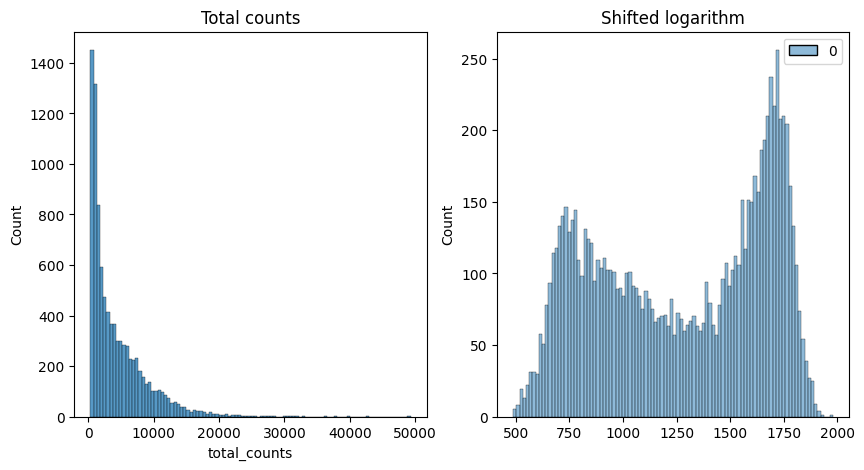

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adatas[0].obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adatas[0].layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

In [21]:
for adata in adatas:
    adata.write(f"GSE157827_RAW\clean_data\{adata.obs['Patient'][0]}_normalization.h5")

<string>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\c'
<string>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\c'
C:\Users\User\AppData\Local\Temp\ipykernel_27500\651029443.py:2: SyntaxWarning: invalid escape sequence '\{'
  adata.write(f"GSE157827_RAW\clean_data\{adata.obs['Patient'][0]}_normalization.h5")
C:\Users\User\AppData\Local\Temp\ipykernel_27500\651029443.py:2: SyntaxWarning: invalid escape sequence '\c'
  adata.write(f"GSE157827_RAW\clean_data\{adata.obs['Patient'][0]}_normalization.h5")
C:\Users\User\AppData\Local\Temp\ipykernel_27500\651029443.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
 

# Feature selection

In [8]:
adatas = []
adatas = [sc.read(f) for f in glob.glob(os.path.join(r"GSE157827_RAW/clean_data", "*_normalization.h5"))]

In [9]:
import anndata as ad

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=3000, batch_key="sample", layer="log1p_norm", flavor="seurat_v3", subset=True)

ValueError: b'reciprocal condition number  3.4634e-15'

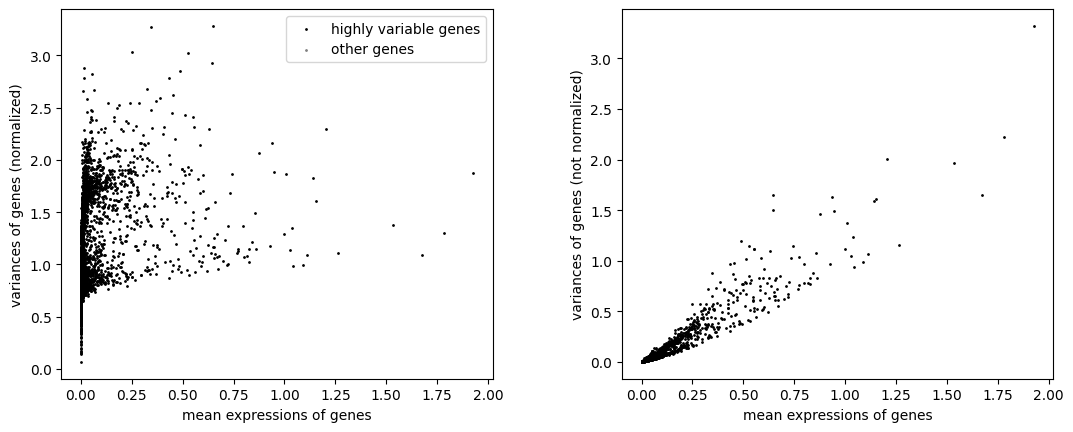

In [81]:
sc.pl.highly_variable_genes(adata)

In [82]:
adata.write(r"GSE157827_RAW\clean_data\MATRIX_feature_selection.h5")

# Integration

In [17]:
import scvi
import anndata as ad

adatas = []
adatas = [sc.read(f) for f in glob.glob(os.path.join(r"GSE157827_RAW/clean_data", "*_quality_control.h5"))]

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()

scvi.model.SCVI.setup_anndata(adata, batch_key="sample")
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training:   0%|          | 0/102 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=102` reached.


In [19]:
model.save(r"GSE157827_RAW/clean_data/scvi_model", overwrite=True)

In [18]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

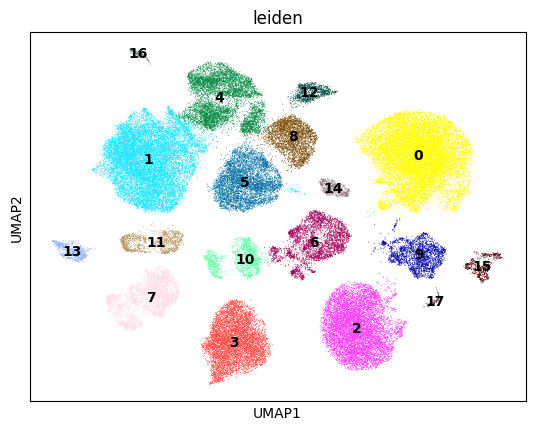

In [22]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata, resolution=0.25)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["leiden"], legend_loc="on data")

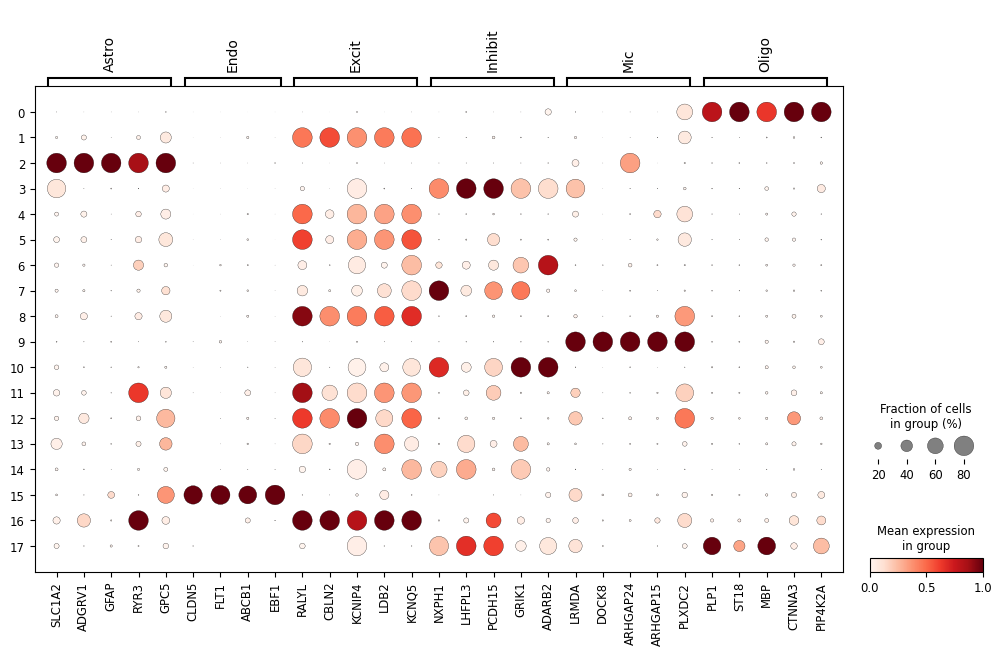

In [ ]:
marker_genes = {
    "Astro": ["SLC1A2", "ADGRV1", "GFAP","RYR3","GPC5"],
    "Endo": ["CLDN5", "FLT1", "ABCB1","EBF1"],
    "Excit": ["RALYL", "CBLN2", "KCNIP4","LDB2","KCNQ5"],
    "Inhibit": ["NXPH1","LHFPL3","PCDH15","GRIK1","ADARB2"],
    "Mic": ["LRMDA","DOCK8","ARHGAP24","ARHGAP15","PLXDC2"],
    "Oligo": ["PLP1", "ST18", "MBP","CTNNA3","PIP4K2A"],
}

marker_genes_present = {
    ct: [g for g in genes if g in adata.var_names]
    for ct, genes in marker_genes.items()
}

sc.pl.dotplot(
    adata,
    marker_genes_present,
    groupby="leiden",
    standard_scale="var",
    dot_max=0.8,
)

In [24]:
adata.write(f"GSE157827_RAW\clean_data\MATRIX_Integration.h5")

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\User\AppData\Local\Temp\ipykernel_27848\576543334.py:1: SyntaxWarning: invalid escape sequence '\c'
  adata.write(f"GSE157827_RAW\clean_data\MATRIX_Integration.h5")


# Dimensionality reduction

In [3]:
adata = sc.read(r"GSE157827_RAW\clean_data\MATRIX_feature_selection.h5")
sc.tl.pca(adata, use_highly_variable=True,layer = 'log1p_norm' ,n_comps=50)
adata.write(r"GSE157827_RAW\clean_data\MATRIX_dimensionality_reduction.h5")

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\preprocessing\_pca\__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


# Integration (python 3.12)

In [1]:
import scvi

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\scvi\_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\scvi\_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-12 16:04:45,915	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-11-12 16:04:47

ImportError: cannot import name 'SparseDataset' from 'anndata._core.sparse_dataset' (c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\sparse_dataset.py)

In [12]:
adata = sc.read(r"GSE157827_RAW\clean_data\MATRIX_feature_selection.h5")
sc.pp.filter_genes(adata, min_cells = 50)

In [8]:
import scib

In [ ]:
sc.tl.pca(adata, use_highly_variable=True, layer="log1p_norm", n_comps=50)
sc.pp.neighbors(adata, use_rep="X_pca")

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_pca\__init__.py:226: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


In [22]:
scib.metrics.kBET(adata, batch_key="Patient", type_='kNN', label_key=None)

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


ValueError: column None is not in obs

In [10]:
model_cls = scvi.model.SCVI
model_cls.setup_anndata(adata, categorical_covariate_keys=['Patient'], continuous_covariate_keys=['pct_counts_mt', 'pct_counts_ribo'])
tuner = scvi.autotune.ModelTuner(model_cls)

AttributeError: module 'scvi' has no attribute 'autotune'

In [7]:
adata

AnnData object with n_obs × n_vars = 79014 × 23743
    obs: 'Patient', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'outlier', 'mt_outlier', 'doublet', 'doublet_score', 'sample'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'n_cells'
    uns: 'hvg'
    layers: 'log1p_norm'

# Annotation

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\preprocessing\_pca\__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


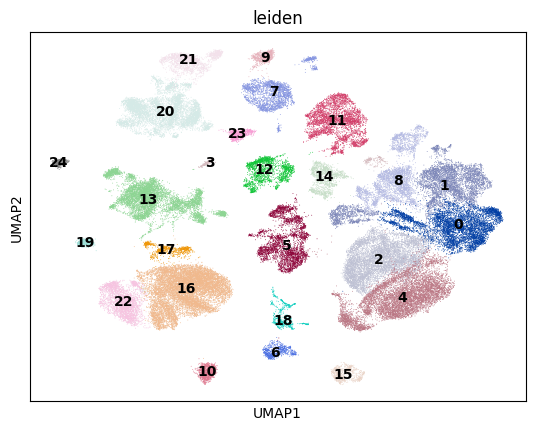

In [83]:
adata = sc.read(r"GSE157827_RAW\clean_data\MATRIX_feature_selection.h5")
sc.tl.pca(adata, use_highly_variable=True,layer = 'log1p_norm' ,n_comps=50)
sc.pp.neighbors(adata, use_rep="X_pca")
# 2. UMAP (proyección 2D)
sc.tl.umap(adata)

# 3. Clustering (Leiden)
sc.tl.leiden(adata, resolution=0.25, flavor="igraph", n_iterations=2)

# 4. Visualización
sc.pl.umap(adata, color=["leiden"], legend_loc="on data")

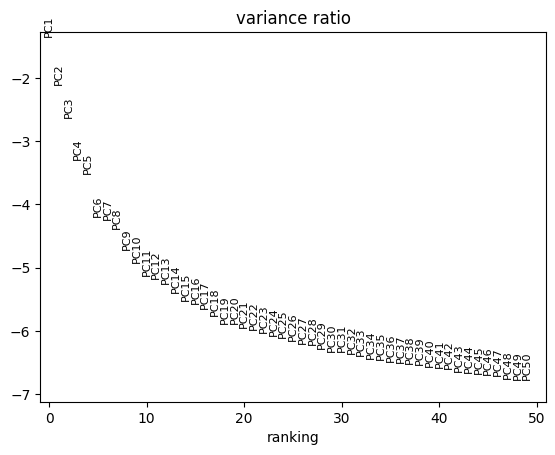

In [84]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\preprocessing\_pca\__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


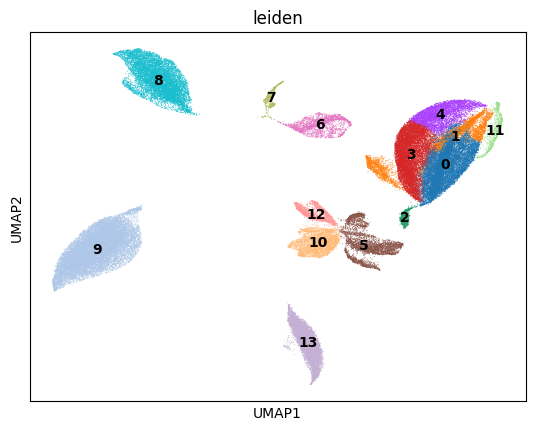

In [51]:
adata = sc.read(r"GSE157827_RAW\clean_data\MATRIX_feature_selection.h5")
sc.tl.pca(adata, use_highly_variable=True,n_comps=50)
sc.pp.neighbors(adata, use_rep="X_pca")
# 2. UMAP (proyección 2D)
sc.tl.umap(adata)

# 3. Clustering (Leiden)
sc.tl.leiden(adata, resolution=0.25, flavor="igraph", n_iterations=2)

# 4. Visualización
sc.pl.umap(adata, color=["leiden"], legend_loc="on data")

In [85]:
marker_genes = {
    "Astro": ["SLC1A2", "ADGRV1", "GFAP","RYR3","GPC5"],
    "Endo": ["CLDN5", "FLT1", "ABCB1","EBF1"],
    "Excit": ["RALYL", "CBLN2", "KCNIP4","LDB2","KCNQ5"],
    "Inhibit": ["NXPH1","LHFPL3","PCDH15","GRIK1","ADARB2"],
    "Mic": ["LRMDA","DOCK8","ARHGAP24","ARHGAP15","PLXDC2"],
    "Oligo": ["PLP1", "ST18", "MBP","CTNNA3","PIP4K2A"],
}


In [ ]:
marker_genes_present = {
    ct: [g for g in genes if g in adata.var_names]
    for ct, genes in marker_genes.items()
}


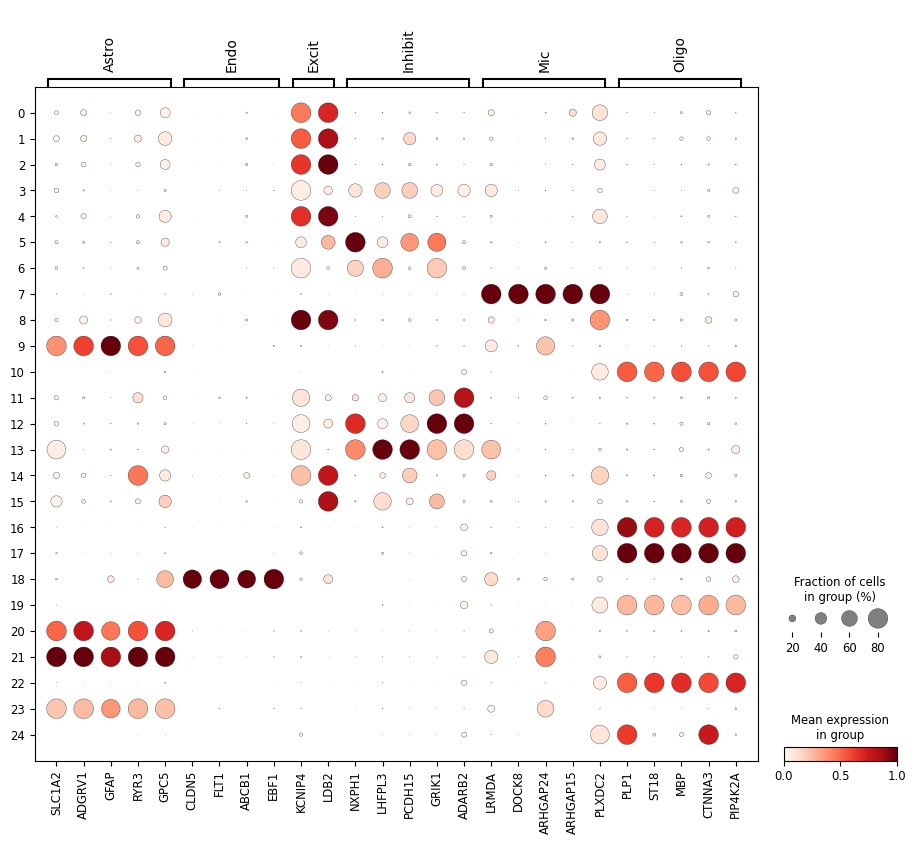

In [87]:
sc.pl.dotplot(
    adata,
    marker_genes_present,
    groupby="leiden",
    standard_scale="var",
    dot_max=0.8,
)


In [ ]:
annotation_map = {
    # Excit
    '0': 'Excit', '1': 'Excit', '2': 'Excit', '4': 'Excit', '8': 'Excit', '14': 'Excit', '15': 'Excit',
    
    # Inhibit
    '5': 'Inhibit', '11': 'Inhibit', '12': 'Inhibit', '13': 'Inhibit',
    
    # Astro
    '9': 'Astro', '20': 'Astro', '21': 'Astro', '23': 'Astro',
    
    # Oligo
    '10': 'Oligo', '16': 'Oligo', '17': 'Oligo', '19':'Oligo', '22': 'Oligo', '24': 'Oligo',
    
    # Mic
    '7': 'Mic',
    
    # Endo
    '18': 'Endo',
    
    # Sin identificar
    '3': 'Sin identificar', '6': 'Sin identificar'
}

adata.obs['cell_type'] = adata.obs['leiden'].map(annotation_map)
print("Conteo de células por tipo celular anotado:")
print(adata.obs['cell_type'].value_counts())

adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')

Conteo de células por tipo celular anotado:
cell_type
Excit              31955
Oligo              16808
Inhibit            16279
Astro               9240
Mic                 2422
Sin identificar     1164
Endo                 609
Name: count, dtype: int64


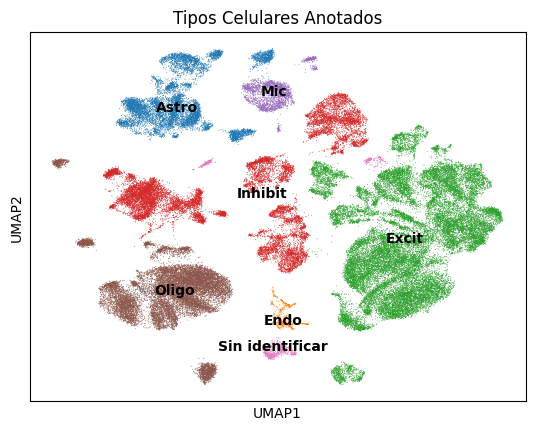

In [89]:
sc.pl.umap(adata, color='cell_type', legend_loc='on data', title='Tipos Celulares Anotados')

# Subcluster analysis

In [ ]:

adata_oligo = adata[adata.obs['cell_type'] == 'Oligo'].copy()

print(f"Número de células en el objeto original: {adata.n_obs}")
print(f"Número de células en el nuevo objeto 'Oligo': {adata_oligo.n_obs}")

Número de células en el objeto original: 78477
Número de células en el nuevo objeto 'Oligo': 16808


In [ ]:

sc.pp.highly_variable_genes(adata_oligo, n_top_genes=3000, batch_key="Patient", layer="log1p_norm")

sc.tl.pca(adata_oligo, use_highly_variable=True,layer = 'log1p_norm' ,n_comps=50)


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:693: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  df = _highly_variable_genes_batched(
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\preprocessing\_pca\__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


In [ ]:
sc.pp.neighbors(adata_oligo, use_rep="X_pca")

sc.tl.umap(adata_oligo)

sc.tl.leiden(adata_oligo, resolution=0.5, key_added='leiden_sub')

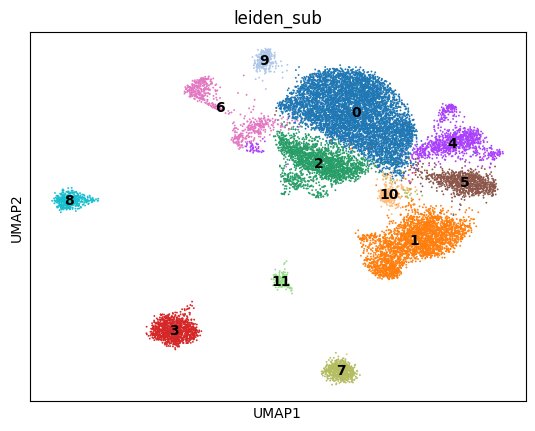

In [ ]:
sc.pl.umap(adata_oligo, color=["leiden_sub"], legend_loc="on data")

In [ ]:
adata_oligo.obs['diagnosis'] = adata_oligo.obs['Patient'].str[:2]

print("Conteo de oligodendrocitos por condición:")
print(adata_oligo.obs['diagnosis'].value_counts())

Conteo de oligodendrocitos por condición:
diagnosis
NC    9375
AD    7433
Name: count, dtype: int64


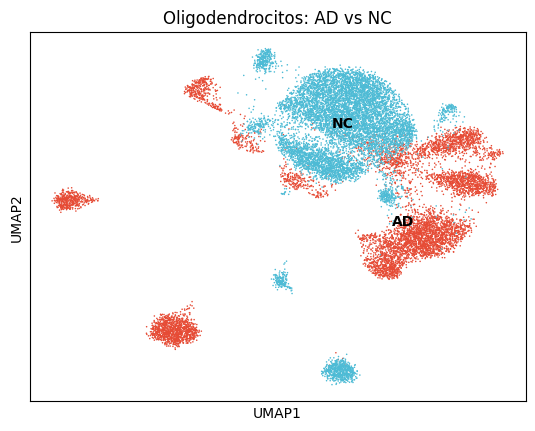

In [ ]:
import scanpy as sc

sc.pl.umap(
    adata_oligo,
    color="diagnosis",
    title="Oligodendrocitos: AD vs NC",
    palette=["#E64B35", "#4DBBD5"],
    legend_loc="on data",
    size=5
)
